In [ ]:
from __future__ import division
import glob
from itertools import chain
import torchvision
import os
import random
import zipfile
import matplotlib.pyplot as plt
import numpy as np
from numpy import dot
from numpy.linalg import norm
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import gc
import requests


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
PATH = '/content/drive/MyDrive/ResneXt/model_best.pth.tar'

In [ ]:
trainset = testset = torchvision.datasets.CIFAR100(root = './sample_data', train = True,  download = True, transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025))]))

Files already downloaded and verified


In [ ]:
testset = torchvision.datasets.CIFAR100(root = './sample_data', train = False,  download = True, transform = transforms.Compose([transforms.ToTensor()]))#, transforms.Normalize((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025))]))

Files already downloaded and verified


In [ ]:
train_loader = torch.utils.data.DataLoader(trainset,batch_size = 1000, shuffle = True)
test_loader = torch.utils.data.DataLoader(testset, batch_size = 100, shuffle = False)

In [ ]:
train_images =[]
for image,label in train_loader:
    train_images.append(image.numpy())
train_images = [item for elem in train_images for item in elem]
train_images  = np.array(train_images).transpose(0,2,3,1)


In [ ]:
train_images= [(np.reshape(image,(32*32*3))) for image in train_images]

In [ ]:
pca = PCA(n_components = 200,whiten=True)
#x_train = normalize(train_images , norm="l2")
pca.fit(train_images)

PCA(n_components=200, whiten=True)

In [ ]:
__all__ = ['resnext']

class ResNeXtBottleneck(nn.Module):
    """
    RexNeXt bottleneck type C (https://github.com/facebookresearch/ResNeXt/blob/master/models/resnext.lua)
    """
    def __init__(self, in_channels, out_channels, stride, cardinality, widen_factor):
        """ Constructor
        Args:
            in_channels: input channel dimensionality
            out_channels: output channel dimensionality
            stride: conv stride. Replaces pooling layer.
            cardinality: num of convolution groups.
            widen_factor: factor to reduce the input dimensionality before convolution.
        """
        super(ResNeXtBottleneck, self).__init__()
        D = cardinality * out_channels // widen_factor
        self.conv_reduce = nn.Conv2d(in_channels, D, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn_reduce = nn.BatchNorm2d(D)
        self.conv_conv = nn.Conv2d(D, D, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
        self.bn = nn.BatchNorm2d(D)
        self.conv_expand = nn.Conv2d(D, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn_expand = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut.add_module('shortcut_conv', nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False))
            self.shortcut.add_module('shortcut_bn', nn.BatchNorm2d(out_channels))

    def forward(self, x):
        bottleneck = self.conv_reduce.forward(x)
        bottleneck = F.relu(self.bn_reduce.forward(bottleneck), inplace=True)
        bottleneck = self.conv_conv.forward(bottleneck)
        bottleneck = F.relu(self.bn.forward(bottleneck), inplace=True)
        bottleneck = self.conv_expand.forward(bottleneck)
        bottleneck = self.bn_expand.forward(bottleneck)
        residual = self.shortcut.forward(x)
        return F.relu(residual + bottleneck, inplace=True)


class CifarResNeXt(nn.Module):
    """
    ResNext optimized for the Cifar dataset, as specified in
    https://arxiv.org/pdf/1611.05431.pdf
    """
    def __init__(self, cardinality, depth, num_classes, widen_factor=4, dropRate=0):
        """ Constructor
        Args:
            cardinality: number of convolution groups.
            depth: number of layers.
            num_classes: number of classes
            widen_factor: factor to adjust the channel dimensionality
        """
        super(CifarResNeXt, self).__init__()
        self.cardinality = cardinality
        self.depth = depth
        self.block_depth = (self.depth - 2) // 9
        self.widen_factor = widen_factor
        self.num_classes = num_classes
        self.output_size = 64
        self.stages = [64, 64 * self.widen_factor, 128 * self.widen_factor, 256 * self.widen_factor]

        self.conv_1_3x3 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.bn_1 = nn.BatchNorm2d(64)
        self.stage_1 = self.block('stage_1', self.stages[0], self.stages[1], 1)
        self.stage_2 = self.block('stage_2', self.stages[1], self.stages[2], 2)
        self.stage_3 = self.block('stage_3', self.stages[2], self.stages[3], 2)
        self.classifier = nn.Linear(1024, num_classes)
        init.kaiming_normal(self.classifier.weight)

        for key in self.state_dict():
            if key.split('.')[-1] == 'weight':
                if 'conv' in key:
                    init.kaiming_normal(self.state_dict()[key], mode='fan_out')
                if 'bn' in key:
                    self.state_dict()[key][...] = 1
            elif key.split('.')[-1] == 'bias':
                self.state_dict()[key][...] = 0

    def block(self, name, in_channels, out_channels, pool_stride=2):
        """ Stack n bottleneck modules where n is inferred from the depth of the network.
        Args:
            name: string name of the current block.
            in_channels: number of input channels
            out_channels: number of output channels
            pool_stride: factor to reduce the spatial dimensionality in the first bottleneck of the block.
        Returns: a Module consisting of n sequential bottlenecks.
        """
        block = nn.Sequential()
        for bottleneck in range(self.block_depth):
            name_ = '%s_bottleneck_%d' % (name, bottleneck)
            if bottleneck == 0:
                block.add_module(name_, ResNeXtBottleneck(in_channels, out_channels, pool_stride, self.cardinality,
                                                          self.widen_factor))
            else:
                block.add_module(name_,
                                 ResNeXtBottleneck(out_channels, out_channels, 1, self.cardinality, self.widen_factor))
        return block

    def forward(self, x):
        x = self.conv_1_3x3.forward(x)
        x = F.relu(self.bn_1.forward(x), inplace=True)
        x = self.stage_1.forward(x)
        x = self.stage_2.forward(x)
        x = self.stage_3.forward(x)
        x = F.avg_pool2d(x, 8, 1)
        x = x.view(-1, 1024)
        x = self.classifier(x)
        return x

def resnext(**kwargs):
    """Constructs a ResNeXt.
    """
    model = CifarResNeXt(**kwargs)
    return model

In [ ]:
model = CifarResNeXt(cardinality = 16, depth = 29, num_classes = 100, dropRate = 0)
model = torch.nn.DataParallel(model).cuda()
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['state_dict'])
model = model.module
model.classifier = nn.Linear(1024, 3072)
#model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.cuda()

In [ ]:
def features_extraction_pipeline(x):
        x = model(x.cuda())
        x = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2)
        x = x.detach().cpu().numpy()
        x = normalize(x, norm='l2')
        x = pca.transform(x)  
        x = normalize(x, norm='l2')
        
        return x
    

In [ ]:
labels = []
original_images = []
extracted_features = []
with torch.no_grad():
    for image,label in test_loader:
        original_images.append(image.numpy())
        features = features_extraction_pipeline(image)
        labels.append(label.numpy())
        extracted_features.append(features)
extracted_features = [item for elem in extracted_features for item in elem]
original_images = [item for elem in original_images for item in elem]
labels = [item for elem in labels for item in elem]
extracted_features = np.array(extracted_features)
original_images  = np.array(original_images).transpose(0,2,3,1)
labels = np.array(labels)

In [ ]:
query_labels = [5,60,12,17,19,24,26,33,32,36,30,3808,117,279,319,329,339,373,377,379,439,499,493,495,498] 

In [ ]:
query = [extracted_features[x] for x in query_labels]

In [ ]:
def similarity_measure(query,extracted_features, cosine = False):
        images = pow(query - extracted_features,2).sum()
    
        return images

In [ ]:
idx = []
for i in range(len(query)):
    for j in range(len(extracted_features)):
        idx.append(similarity_measure(query[i],extracted_features[j]))
idx = np.array(idx)
idx = idx.reshape(len(query),len(extracted_features))
idx = np.argsort(idx)[:,:11]

In [ ]:
final = original_images[idx]

In [ ]:
def viz(q):    
    plt.figure(figsize=(15,15)) 

    for i in range(11):

       plt.subplot(1,11,i+1) 
       plt.imshow(final[q][i])

    plt.show()

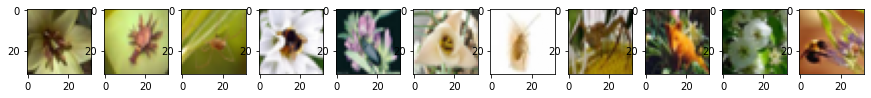

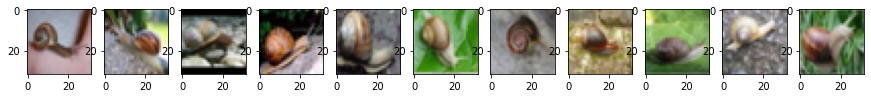

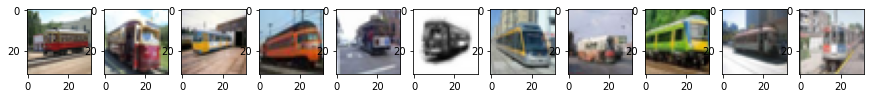

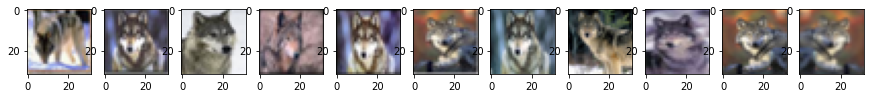

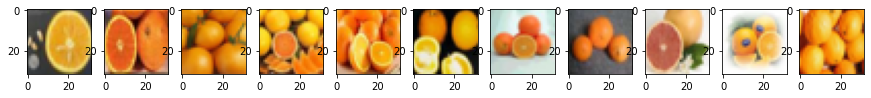

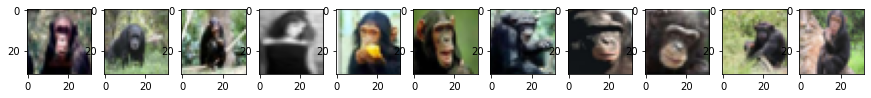

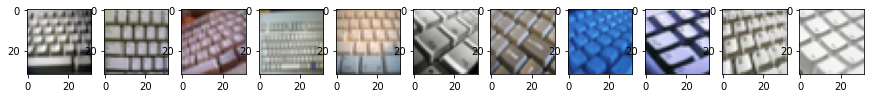

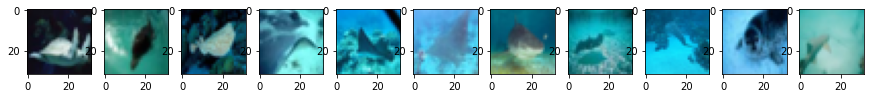

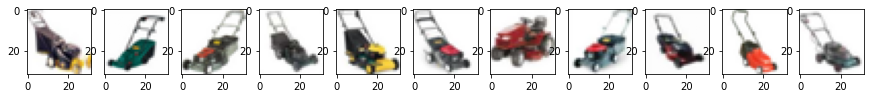

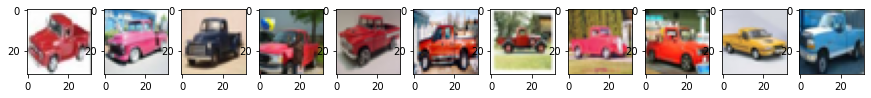

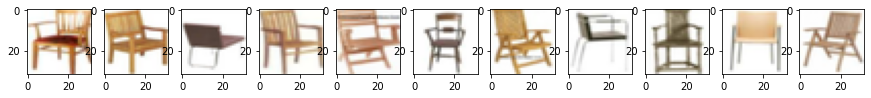

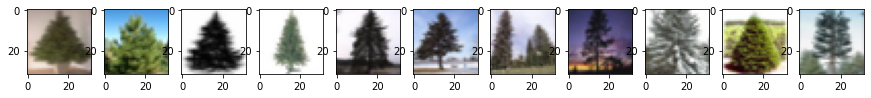

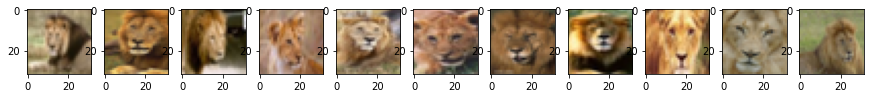

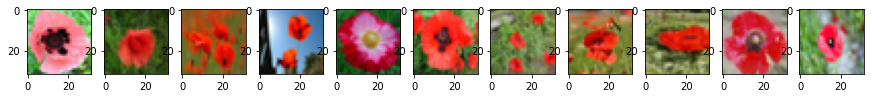

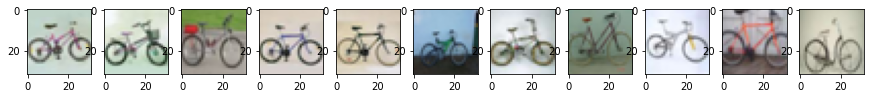

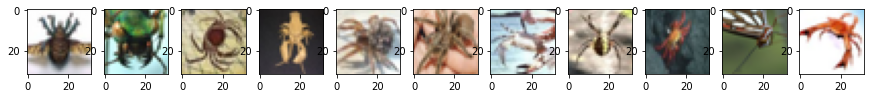

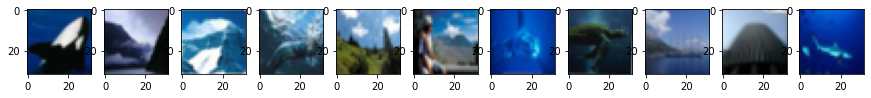

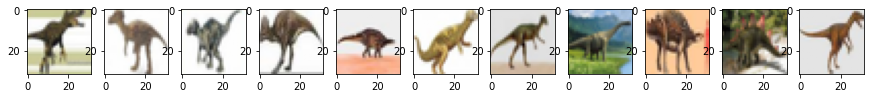

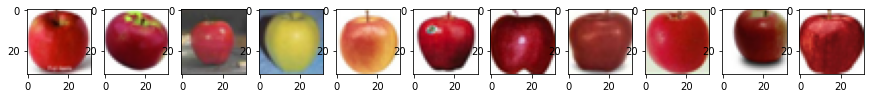

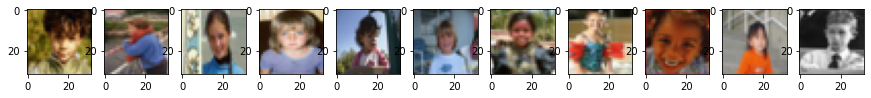

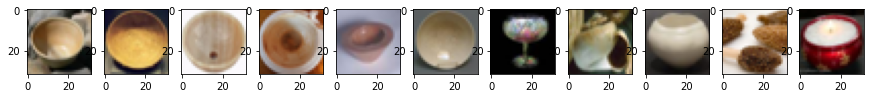

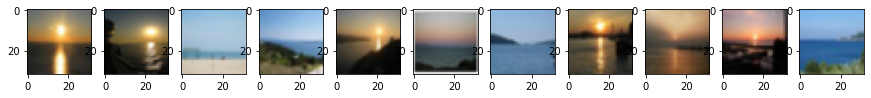

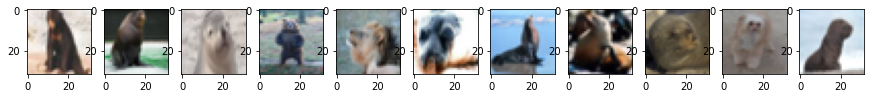

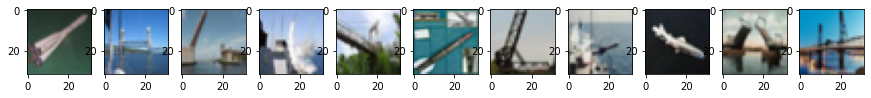

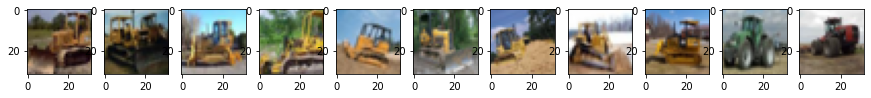

In [ ]:
for i in range(len(final)):
    viz(i)